In [80]:
!git clone https://github.com/djaniak/ai-tech-workshop-repr-ood.git

In [81]:
!mv ai-tech-workshop-repr-ood/* .

In [1]:
!pip install -r requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2

In [100]:
import os
from typing import Any, Union, Optional

import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
import torchvision
import tqdm
import pytorch_lightning as pl
from pl_bolts.datamodules import CIFAR10DataModule
from pytorch_lightning import LightningModule, Trainer, seed_everything
import umap

In [8]:
DATASET_PATH = os.environ.get("DATASET_PATH", "data/")

# Setting the seed
seed_everything(997)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Global seed set to 997


# Supervised

Supervised representation learning refers to a machine learning approach where a model is trained to automatically learn meaningful representations or features from labeled data. In supervised learning, the dataset consists of input data samples paired with corresponding target labels, and the goal is to learn a mapping between the inputs and the desired outputs.

In the context of representation learning, the focus is on learning a compact and informative representation of the input data that captures its underlying structure and discriminative properties. Instead of relying on handcrafted features, supervised representation learning enables the model to automatically discover relevant features directly from the raw input data.

Supervised representation learning typically involves training a deep neural network, such as a convolutional neural network (CNN) for image data or a recurrent neural network (RNN) for sequential data. The network is initialized with random weights and then optimized using gradient-based methods to minimize a predefined objective function, such as cross-entropy loss.

During training, the model learns to transform the input data into a representation that is conducive to the task at hand. The model adjusts its internal parameters to minimize the discrepancy between the predicted outputs and the true labels provided in the training data. As a result, the model learns to extract relevant features from the data that are useful for discriminating between different classes or making accurate predictions.

Supervised representation learning has been widely applied to various domains, including computer vision, natural language processing, and speech recognition. By learning representations directly from labeled data, these models can achieve superior performance compared to traditional feature engineering approaches, as they can capture more intricate patterns and relationships in the data.

#### Original ResNet18 architecture

![resnet](https://www.researchgate.net/publication/336642248/figure/fig1/AS:839151377203201@1577080687133/Original-ResNet-18-Architecture.png)

Ramzan, Farheen & Khan, Muhammad Usman & Rehmat, Asim & Iqbal, Sajid & Saba, Tanzila & Rehman, Amjad & Mehmood, Zahid. (2019). A Deep Learning Approach for Automated Diagnosis and Multi-Class Classification of Alzheimer’s Disease Stages Using Resting-State fMRI and Residual Neural Networks. Journal of Medical Systems. 44. 10.1007/s10916-019-1475-2. 

Code based on https://lightning.ai/docs/pytorch/stable/notebooks/lightning_examples/cifar10-baseline.html

We will use a modified pre-existing Resnet architecture from TorchVision. The pre-existing architecture is based on ImageNet images (224x224) as input. So we need to modify it for CIFAR10 images (32x32).

In [4]:
from IPython.display import Code, display

# display(Code(filename="src/model/resnet.py"))

We will first load ResNet model and CIFAR10 dataset and validate it on test dataset.

In [ ]:
from torchvision.datasets import CIFAR10

CIFAR10(root=DATASET_PATH, download=True, train=True)
CIFAR10(root=DATASET_PATH, download=True, train=False)

In [5]:
from src.data.transforms import get_supervised_transforms

train_transforms, val_transforms, test_transforms = get_supervised_transforms()
dm_resnet = CIFAR10DataModule(
    data_dir=DATASET_PATH,
    batch_size=256,
    num_workers=0,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    val_transforms=val_transforms,
)
dm_resnet.setup()

In [7]:
from src.model.resnet import LitResnet

ckpt_path = "saved_models/resnet/model.ckpt"
model_resnet = LitResnet.load_from_checkpoint(ckpt_path).eval()

In [ ]:
trainer = pl.Trainer(accelerator="auto", devices=1)
trainer.test(model_resnet, datamodule=dm_resnet)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


/opt/anaconda3/envs/ai-tech2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9168999791145325     │
│         test_ece          │   0.051908861845731735    │
│         test_loss         │    0.2843647599220276     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2843647599220276,
  'test_acc': 0.9168999791145325,
  'test_ece': 0.051908861845731735}]

## Calculate metrics

A network should provide a calibrated confidence measure in addition to its prediction. In other words, the probability associated with the predicted class label should reflect its ground truth correctness likelihood. Calibrated confidence estimates are also important for model interpretability. Humans have a natural cognitive in- tuition for probabilities (Cosmides & Tooby, 1996). Good confidence estimates provide a valuable extra bit of infor- mation to establish trustworthiness with the user – espe- cially for neural networks, whose classification decisions are often difficult to interpret. Further, good probability estimates can be used to incorporate neural networks into other probabilistic models. 

Reference: Guo, Chuan, et al. "On calibration of modern neural networks." International conference on machine learning. PMLR, 2017.


**Reliability Diagrams** (e.g. Figure 1 bottom) are a visual representation of model calibration (DeGroot & Fienberg, 1983; Niculescu-Mizil & Caruana, 2005). These diagrams plot expected sample accuracy as a function of confidence. If the model is perfectly calibrated – i.e. if (1) holds – then the diagram should plot the identity function. Any devia- tion from a perfect diagonal represents miscalibration.

![](https://i.imgur.com/ecR1QTl.png)

While reliability diagrams are useful visual tools, it is more convenient to have a scalar summary statistic of calibration. Since statis- tics comparing two distributions cannot be comprehensive, previous works have proposed variants, each with a unique emphasis. One notion of miscalibration is the difference in expectation between confidence and accuracy, which **expected calibratior error** approximates.

The **expected calibration error (ECE)** can be used to quantify how well a given model is calibrated e.g. how well the predicted output probabilities of the model matches the actual probabilities of the ground truth distribution.

![](https://torchmetrics.readthedocs.io/en/stable/_images/math/05e4eb289eeff9cbcfa8b06bd3567f50b5b1b94b.png)

Let's create a simple reliability diagram for our model!

In [ ]:
from src.utils.utils import get_preds_and_labels

preds, target = get_preds_and_labels(
    model=model_resnet.to(device), dataloader=dm_resnet.test_dataloader(), device=device
)

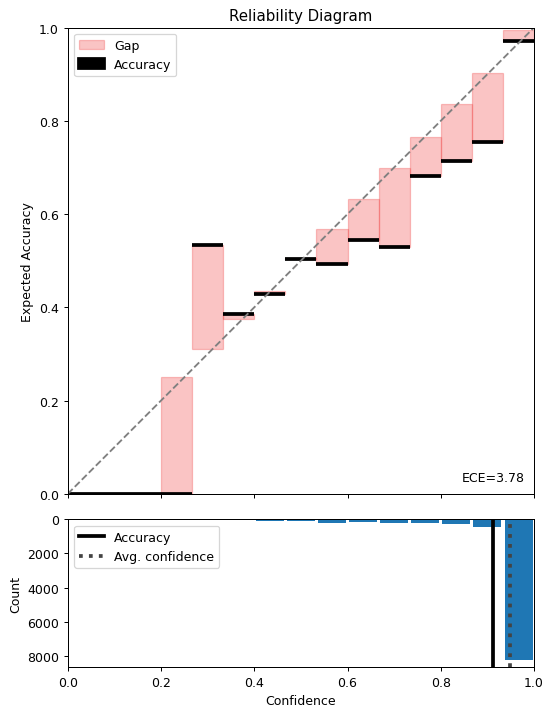

In [ ]:
from src.utils.rel import reliability_diagram

fig = reliability_diagram(
    true_labels=target.numpy(),
    pred_labels=torch.argmax(preds, dim=1).numpy(),
    confidences=torch.max(preds, dim=1).values.numpy(),
    num_bins=15,
    dpi=90,
    return_fig=True,
)

## Extracting features

Ok, we now see that our model in fitted as we valdiated it on the test dataset. We want to extract features that can be used as a representation to see what our model has learnt.

Here is snippet from the torch ResNet implementation:

```
    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)
```

## Exercise 1:
### Implement a function that extract features from the ResNet model. Then follow and extract the features.

In [ ]:
class MyResnet(LitResnet):
    device = (
        torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    )

    def _forward_features(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

    def extract_features(self, dataloader):
        features = []
        labels = []
        for batch in tqdm.tqdm(dataloader, total=len(dataloader)):
            x, y = batch
            with torch.no_grad():
                batch_feats = self._forward_features(x.to(self.device)).cpu()
            features.append(batch_feats)
            labels.append(y)
        features = torch.vstack(features)
        labels = torch.hstack(labels)
        return features, labels

In [111]:
model_resnet = MyResnet.load_from_checkpoint(ckpt_path).eval()
model_resnet = model_resnet.to(device)

In [109]:
train_resnet_features, train_resnet_labels = model_resnet.extract_features(
    dataloader=dm_resnet.train_dataloader()
)
test_resnet_features, test_resnet_labels = model_resnet.extract_features(
    dataloader=dm_resnet.test_dataloader()
)

 30%|███       | 12/40 [00:33<01:17,  2.78s/it]


KeyboardInterrupt: 

## UMAP

Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data

- The data is uniformly distributed on Riemannian manifold;
- The Riemannian metric is locally constant (or can be approximated as such);
- The manifold is locally connected.

From these assumptions it is possible to model the manifold with a fuzzy topological structure. The embedding is found by searching for a low dimensional projection of the data that has the closest possible equivalent fuzzy topological structure.

In [ ]:
resnet_mapper = umap.UMAP().fit(train_resnet_features)
projected_resnet_features = resnet_mapper.transform(test_resnet_features)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<Axes: >

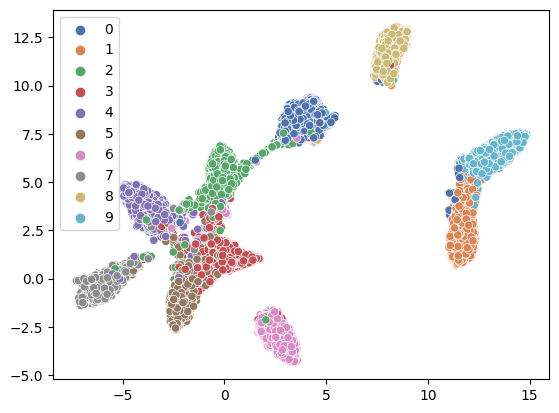

In [ ]:
sns.scatterplot(
    x=projected_resnet_features[:, 0],
    y=projected_resnet_features[:, 1],
    hue=test_resnet_labels,
    palette="deep",
)

# Self-supervised

Self-supervised learning offers a compelling solution as it utilizes the input data itself as supervision, eliminating the reliance on external labels. It uses self-defined signals to create a proxy objective between input and signal. The signal used in self-supervised learning acts as a guiding principle, influencing the choice of architecture and methodology for the representation learning task.

### Generative

![image.png](https://www.researchgate.net/publication/355850728/figure/fig4/AS:1085699449200644@1635862328517/Examples-of-generative-models-From-top-to-bottom-Variational-Autoencoder-VAE-and.png)

Examples of generative models. From [1].

[1] Defresne, Marianne & Barbe, Sophie & Schiex, Thomas. (2021). Protein Design with Deep Learning. International Journal of Molecular Sciences. 22. 11741. 10.3390/ijms222111741. 

Generative models are based reconstruction and typically learn by maximizing the likelihood of generating reconstructed data from the input. 

The main advantage of generative approaches is their ability to capture the full data distribution and generate new samples. While generative models can provide valuable insights into the data distribution, they may not always produce representations that are directly optimized for discriminative tasks [2]. 

The most common examples of generative architectures include autoencoders, variational autoencoders (VAEs) [3], generative adversarial networks (GANs) [4], or flow-based models [5]. 

Autoencoders are neural networks that learn to encode input data into a lower-dimensional representation (encoder) and then reconstruct the original input from the encoded representation (decoder). 

VAEs are a variation of autoencoders that incorporate probabilistic modeling and are salient from the perspective of this research proposal. They learn to generate data by sampling from a latent space distribution and reconstructing the input data. VAEs are trained by maximizing a lower bound on the log-likelihood of the data, encouraging the learned latent space to capture meaningful variations in the data. 

[2] Liu, Xiao, et al. "Self-supervised learning: Generative or contrastive." IEEE Transactions on Knowledge and Data Engineering 35.1 (2021): 857-876.
[3]
[4]
[5]

### Autoencoder

In general, an autoencoder consists of an encoder that maps the input x to a lower-dimensional feature vector z, and a decoder that reconstructs the input $\hat{x}$ from $z$. We train the model by comparing $x$ to $\hat{x}$ and optimizing the parameters to increase the similarity between x and $\hat{x}$. See below for a small illustration of the autoencoder framework.

<img src="https://lilianweng.github.io/posts/2018-08-12-vae/autoencoder-architecture.png"  width="60%">

Credits: [Lilian Weng's blog post about VAEs](https://lilianweng.github.io/posts/2018-08-12-vae/)

Let's create datamodule. This time we will use different transforms for our dataset. In this case, we do not normalize the data explicitly with a mean of 0 and std of 1 (as in supervised case), but roughly estimate it scaling the data between -1 and 1. This is because limiting the range will make our task of predicting/reconstructing images easier.

In [13]:
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)

dm_ae = CIFAR10DataModule(
    data_dir=DATASET_PATH,
    batch_size=256,
    num_workers=4,
    train_transforms=transforms,
    test_transforms=transforms,
    val_transforms=transforms,
)
dm_ae.setup()

Here, we will follow [lightning-bolts](https://lightning-bolts.readthedocs.io/en/latest/models/autoencoders.html#basic-ae) library to implement our own autoencoder.

We will use an autoencoder already pretrained on CIFAR10 with resnet18 backbone.


In [10]:
from pl_bolts.models.autoencoders import AE

ae = AE(input_height=32)
print(AE.pretrained_weights_available())
ae = ae.from_pretrained("cifar10-resnet18")

ae.freeze()

/var/folders/ng/6_1zhqwn18sbhwvrkn_9fcxr0000gn/T/ipykernel_20043/4261973159.py:3: UnderReviewWarning: The feature AE is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  ae = AE(input_height=32)
/opt/anaconda3/envs/ai-tech2/lib/python3.9/site-packages/pl_bolts/models/autoencoders/basic_ae/basic_ae_module.py:86: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = valid_encoders[enc_type]["enc"](first_conv, maxpool1)
/opt/anaconda3/envs/ai-tech2/lib/python3.9/site-pack

['cifar10-resnet18']


/opt/anaconda3/envs/ai-tech2/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:224: UnderReviewWarning: The feature AE is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  obj = cls(**_cls_kwargs)


## Exercise:
Similarly as in supervised case, implement a function that extract features from the autoencoder model. Then follow and extract the features.

In [ ]:
class MyAE(AE):
    device = (
        torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    )

    def _forward_features(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

    def extract_features(
        self, dataloader: DataLoader
    ) -> tuple[torch.Tensor, torch.Tensor]:
        features = []
        labels = []
        for batch in tqdm.tqdm(dataloader, total=len(dataloader)):
            x, y = batch
            with torch.no_grad():
                batch_feats = self._forward_features(x.to(self.device)).cpu()
            features.append(batch_feats)
            labels.append(y)
        features = torch.vstack(features)
        labels = torch.hstack(labels)
        return features, labels

In [110]:
model_ae = MyAE(input_height=32)
print(AE.pretrained_weights_available())
model_ae = model_ae.from_pretrained("cifar10-resnet18")
model_ae = model_ae.to(device)

model_ae.freeze()

/var/folders/ng/6_1zhqwn18sbhwvrkn_9fcxr0000gn/T/ipykernel_20043/2400462121.py:1: UnderReviewWarning: The feature AE is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  model_ae = MyAE(input_height=32)
/opt/anaconda3/envs/ai-tech2/lib/python3.9/site-packages/pl_bolts/models/autoencoders/basic_ae/basic_ae_module.py:86: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = valid_encoders[enc_type]["enc"](first_conv, maxpool1)
/opt/anaconda3/envs/ai-tech2/lib/python3.9/s

['cifar10-resnet18']


/opt/anaconda3/envs/ai-tech2/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:224: UnderReviewWarning: The feature AE is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  obj = cls(**_cls_kwargs)


In [ ]:
train_ae_features, train_ae_labels = model_ae.extract_features(
    dataloader=dm_ae.train_dataloader()
)
test_ae_features, test_ae_labels = model_ae.extract_features(
    dataloader=dm_ae.test_dataloader()
)

100%|██████████| 40/40 [01:18<00:00,  1.97s/it]


## UMAP

In [ ]:
ae_mapper = umap.UMAP().fit(train_ae_features)
projected_ae_features = ae_mapper.transform(test_ae_features)

In [ ]:
sns.scatterplot(
    x=projected_ae_features[:, 0],
    y=projected_ae_features[:, 1],
    hue=test_ae_labels,
    palette="deep",
)

torch.Size([10000, 512])

## Discriminative performance 

Let's now check discriminative performance of our variatipnal autoencoder to see whether there is correlation between OOD detection ability and discriminative power of a representation. Let's also see whether it produces better representations in comparison to regular autoencoder.

### Exercise 
Implement AEClassifier in PyTorch Lightning to train a simple classifier with representation from autoencoder latent space.

We will use BaseClassifier class so we only need to implement `__init__` and `forward` methods.

Then follow and fit and test the classifier.

In [108]:
from src.model.base_classifier import BaseClassifier

class AEClassifier(BaseClassifier):
    def __init__(
        self,
        model: AE,
        lr: float = 1e-3,
        batch_size: int = 256,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["model"])

        self.model = model

        # the autoencoder outputs a 512-dim representation and CIFAR-10 has 10 classes
        self.classifier = ...

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

In [17]:
ae_clf = AEClassifier(model=model_ae, lr=1e-2)

trainer = Trainer(
    max_epochs=5,
    accelerator="auto",
    devices=1,
)

trainer.fit(ae_clf, dm_ae)
trainer.test(ae_clf, dm_ae)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name       | Type   | Params
--------------------------------------
0 | model      | AE     | 19.9 M
1 | classifier | Linear | 5.1 K 
--------------------------------------
5.1 K     Trainable params
19.9 M    Non-trainable params
19.9 M    Total params
79.724    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/ai-tech2/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Varational autoencoder

Variational autoencoders (VAEs) are generative models that combine the power of autoencoders with probabilistic inference. They learn to encode input data into a lower-dimensional latent space, capturing its underlying distribution, and then decode it back into reconstructed data. VAEs employ variational inference to optimize the latent space by maximizing the evidence lower bound, enabling them to generate new data samples and perform meaningful data manipulation.

<img src="https://lilianweng.github.io/posts/2018-08-12-vae/vae-gaussian.png"  width="60%">

Credits: [Lilian Weng's blog post about VAEs](https://lilianweng.github.io/posts/2018-08-12-vae/)


In [18]:
from pl_bolts.models.autoencoders import VAE

vae = VAE(input_height=32)
print(VAE.pretrained_weights_available())
vae = vae.from_pretrained("cifar10-resnet18")

vae.freeze()

/var/folders/ng/6_1zhqwn18sbhwvrkn_9fcxr0000gn/T/ipykernel_20043/666860153.py:3: UnderReviewWarning: The feature VAE is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  vae = VAE(input_height=32)
/opt/anaconda3/envs/ai-tech2/lib/python3.9/site-packages/pl_bolts/models/autoencoders/basic_vae/basic_vae_module.py:93: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = valid_encoders[enc_type]["enc"](first_conv, maxpool1)
/opt/anaconda3/envs/ai-tech2/lib/python3.9/site-

['cifar10-resnet18', 'stl10-resnet18']


/opt/anaconda3/envs/ai-tech2/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:224: UnderReviewWarning: The feature VAE is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  obj = cls(**_cls_kwargs)


### Exercise:
Similarly as in autoencoder case, implement a function that extract features from the autoencoder model. Then follow and extract the features.

In [ ]:
class MyVAE(VAE):
    def _forward_features(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

    def extract_features(self, dataloader):
        features = []
        labels = []
        for batch in tqdm.tqdm(dataloader, total=len(dataloader)):
            x, y = batch
            with torch.no_grad():
                batch_feats = self._forward_features(x.to(self.device)).cpu()
            features.append(batch_feats)
            labels.append(y)
        features = torch.vstack(features)
        labels = torch.hstack(labels)
        return features, labels

In [ ]:
model_vae = MyVAE(input_height=32)
print(VAE.pretrained_weights_available())
model_vae = model_vae.from_pretrained("cifar10-resnet18")
model_vae = model_vae.to(device)

model_vae.freeze()

In [ ]:
train_vae_features, train_vae_labels = model_vae.extract_features(
    dataloader=dm_ae.train_dataloader()
)

test_vae_features, test_vae_labels = model_vae.extract_features(
    dataloader=dm_ae.test_dataloader()
)

### UMAP

Let's now see UMAP projections

In [ ]:
import umap

vae_mapper = umap.UMAP().fit(train_vae_features)
projected_vae_features = vae_mapper.transform(test_vae_features)

In [ ]:
sns.scatterplot(
    x=projected_vae_features[:, 0],
    y=projected_vae_features[:, 1],
    hue=test_vae_labels,
    palette="deep",
)

## Discriminative performance 

Let's now check discriminative performance of our variatipnal autoencoder to see whether there is correlation between OOD detection ability and discriminative power of a representation. Let's also see whether it produces better representations in comparison to regular autoencoder.

### Exercise 
Implement VAEClassifier in PyTorch Lightning to train a simple classifier with representation from autoencoder latent space.

We will use BaseClassifier class so we only need to implement `__init__` and `forward` methods.

Then follow and fit and test the classifier.

In [19]:
from src.model.base_classifier import BaseClassifier


class VAEClassifier(BaseClassifier):
    def __init__(self, model: VAE, lr: float = 0.05, batch_size: int = 256):
        super().__init__()
        self.save_hyperparameters(ignore=["model"])

        self.model = model

        # the variational autoencoder outputs a 256-dim representation and CIFAR-10 has 10 classes
        self.classifier = nn.Linear(256, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

In [22]:
vae_clf = VAEClassifier(model=model_vae, lr=1e-2)

trainer = Trainer(
    max_epochs=5,
    accelerator="auto",
    devices=1,
)

trainer.fit(vae_clf, dm_ae)
trainer.test(vae_clf, dm_ae)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name       | Type   | Params
--------------------------------------
0 | model      | VAE    | 20.1 M
1 | classifier | Linear | 2.6 K 
--------------------------------------
2.6 K     Trainable params
20.1 M    Non-trainable params
20.1 M    Total params
80.239    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/anaconda3/envs/ai-tech2/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Contrastive

SimCLR (Chen et al. in 2020) is a self-supervised learning method for computer vision. It maximizes agreement between augmented views of the same image and minimizes agreement between views of different images. It uses data augmentation, an encoder network, projection heads, and a contrastive loss (InfoNCE) to learn meaningful representations from unlabeled data.

<img src="https://www.researchgate.net/publication/354065806/figure/fig1/AS:1059821163929600@1629692464234/Figure-from-6-A-simple-framework-for-contrastive-learning-of-visual-representations.ppm"  width="25%">

Reference: Chen, Ting, et al. "A simple framework for contrastive learning of visual representations." International conference on machine learning. PMLR, 2020.

In [45]:
from pl_bolts.models.self_supervised.simclr.transforms import (
    SimCLREvalDataTransform,
    SimCLRTrainDataTransform,
)

dm_simclr = CIFAR10DataModule(
    data_dir=DATASET_PATH,
    batch_size=256,
    num_workers=0,
    train_transforms=SimCLRTrainDataTransform(input_height=32),
    val_transforms=SimCLREvalDataTransform(input_height=32),
    test_transforms=SimCLREvalDataTransform(input_height=32),
)

dm_simclr.setup()

In [119]:
from pl_bolts.models.self_supervised import SimCLR

weight_path = "https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/simclr-cifar10-sgd/simclr-cifar10-sgd.ckpt"
simclr = SimCLR.load_from_checkpoint(weight_path, strict=False)

simclr.freeze()

/opt/anaconda3/envs/ai-tech2/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:224: UnderReviewWarning: The feature SimCLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  obj = cls(**_cls_kwargs)
/opt/anaconda3/envs/ai-tech2/lib/python3.9/site-packages/pl_bolts/models/self_supervised/simclr/simclr_module.py:138: UnderReviewWarning: The feature resnet50 is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return backbone(first_conv=self.first_conv, maxpool1=self.maxpool1, return_all_feature_maps=False)
/opt/anaconda

Let's extract features

In [120]:
class MySimCLR(SimCLR):
    device = (
        torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    )

    def _forward_features(self, x: torch.Tensor) -> torch.Tensor:
        return self(x)

    def extract_features(
        self, dataloader: DataLoader
    ) -> tuple[torch.Tensor, torch.Tensor]:
        features = []
        labels = []
        for batch in tqdm.tqdm(dataloader, total=len(dataloader)):
            (x1, x2, x3), y = batch
            with torch.no_grad():
                batch_feats = self._forward_features(x3.to(self.device)).cpu()
            features.append(batch_feats)
            labels.append(y)
        features = torch.vstack(features)
        labels = torch.hstack(labels)
        return features, labels

In [121]:
model_simclr = MySimCLR.load_from_checkpoint(weight_path, strict=False)
model_simclr = model_simclr.to(device)

model_simclr.freeze()

In [118]:
train_simclr_features, train_simclr_labels = model_simclr.extract_features(
    dataloader=dm_simclr.train_dataloader()
)
test_simclr_features, test_simclr_labels = model_simclr.extract_features(
    dataloader=dm_simclr.test_dataloader()
)

  1%|          | 1/157 [00:10<27:22, 10.53s/it]


KeyboardInterrupt: 

### UMAP
And see how our UMAP projections look like

In [ ]:
simclr_mapper = umap.UMAP().fit(train_simclr_features)
projected_simclr_features = simclr_mapper.transform(test_simclr_features)

In [52]:
sns.scatterplot(
    x=projected_simclr_features[:, 0],
    y=projected_simclr_features[:, 1],
    hue=test_simclr_labels,
    palette="deep",
)

NameError: name 'projected_simclr_features' is not defined

## Discriminative performance 

Let's now check discriminative performance of our model to see what performance we can get in comparison to supervised case.

In [126]:
from src.model.base_classifier import SimCLRClassifier

simclr_clf = SimCLRClassifier(model=model_simclr, lr=1e-3)

trainer = Trainer(
    max_epochs=3,
    accelerator="auto",
    devices=1,
)

trainer.fit(simclr_clf, dm_simclr)
trainer.test(simclr_clf, dm_simclr)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name       | Type     | Params
----------------------------------------
0 | model      | MySimCLR | 30.0 M
1 | classifier | Linear   | 20.5 K
----------------------------------------
20.5 K    Trainable params
30.0 M    Non-trainable params
30.0 M    Total params
120.130   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/anaconda3/envs/ai-tech2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/ai-tech2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/ai-tech2/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Files already downloaded and verified
Files already downloaded and verified


/opt/anaconda3/envs/ai-tech2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.08309999853372574    │
│         test_ece          │     0.261707603931427     │
│         test_loss         │    0.06943444907665253    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.06943444907665253,
  'test_acc': 0.08309999853372574,
  'test_ece': 0.261707603931427}]

# OOD detection

We will partly utilize [pytorch-ood](https://github.com/kkirchheim/pytorch-ood) library which provides several metrics, detectors and datasets implemented in PyTorch and serves as a great entry point.

In [55]:
!pip install --quiet git+https://github.com/djaniak/pytorch-ood.git

### Metrics

Let's start from the metrics.

Most common metric used in the literature is Area Under the Receiver Operating Characteristic curve (AUROC) metric, which is a threshold-independent performance evaluation.

The ROC curve is a graph showing the true positive rate (tpr = tp/(tp + fn)) and the false positive rate (fpr = fp/(fp + tn)) against each other. Moreover, the AUROC can be interpreted as the prob- ability that a positive example has a greater detector score/value than a negative example (Fawcett, 2005). Consequently, a random positive example detector corresponds to a 50% AUROC, and a “perfect” classifier corresponds to 100%.


The AUROC sidesteps the issue of threshold selection, as does the Area Under the Precision-Recall curve (AUPR) which is sometimes deemed more informative (Manning & Schutze, 1999). This is because the AUROC is not ideal when the positive class and negative class have greatly differing base rates, and the AUPR adjusts for these different positive and negative base rates. For this reason, the AUPR is our second evaluation metric. The PR curve plots the precision (tp/(tp + fp)) and recall (tp/(tp + fn)) against each other. 

The baseline detector has an AUPR approximately equal to the precision (Saito & Rehmsmeier, 2015), and a “perfect” classifier has an AUPR of 100%. Consequently, the base rate of the positive class greatly influences the AUPR, so for detection we must specify which class is positive. In view of this, we show the AUPRs when we treat success/normal classes as positive, and then we show the areas when we treat the error/abnormal classes as positive. We can treat the error/abnormal classes as positive by multiplying the scores by −1 and labeling them positive. 

Reference: Hendrycks, Dan, and Kevin Gimpel. "A baseline for detecting misclassified and out-of-distribution examples in neural networks." arXiv preprint arXiv:1610.02136 (2016).

Here, we will use following metrics:
- AUROC
- AUPR IN
- AUPR OUT
- FPR\@95TPR

In [57]:
from pytorch_ood.utils import OODMetrics

metrics = OODMetrics()

### Datasets

When performing out-of-distribution (OOD) detection, it is common to use different datasets as in-distribution and out-of-distribution datasets. The purpose of using other datasets as in and out datasets is to assess the model's ability to generalize and detect samples that deviate significantly from the training data distribution.

Next, let us determine whether an example is in- or out-of-distribution. We use all test set examples of CIFAR10 as the in-distribution (positive) examples. For out-of-distribution (negative) examples we will use other datasets, such as MNIST, LSUN, TinyImageNet or Textures.

In [59]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as tvt
from pytorch_ood.utils import ToRGB, ToUnknown


from pytorch_ood.dataset.img import (
    LSUNResize,
    Textures,
    TinyImageNetResize,
)
from torch.utils.data import DataLoader

# Setup preprocessing
mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]
trans = tvt.Compose(
    [
        tvt.Resize(size=(32, 32)),
        ToRGB(),
        tvt.ToTensor(),
        tvt.Normalize(std=std, mean=mean),
    ]
)

# Setup datasets
dataset_in_test = CIFAR10(
    root=DATASET_PATH, train=False, transform=trans, download=True
)

# create all OOD datasets - we will use `ToUnknown` transform for labels, setting them to -1
ood_datasets = [Textures, TinyImageNetResize, LSUNResize]
datasets = {}
for ood_dataset in ood_datasets:
    dataset_out_test = ood_dataset(
        root=DATASET_PATH, transform=trans, target_transform=ToUnknown(), download=True
    )
    test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=256)
    datasets[ood_dataset.__name__] = test_loader

# %%

Files already downloaded and verified


  0%|          | 0/4550980 [00:00<?, ?it/s]

Extracting data/Imagenet_resize.tar.gz to data


  0%|          | 0/4688973 [00:00<?, ?it/s]

Extracting data/LSUN_resize.tar.gz to data


#### Maximum Softmax Probability (MSP)

The "Maximum Softmax Probability" method for out-of-distribution (OOD) detection, introduced in the work "A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks," involves computing the maximum probability assigned to the correct class by a neural network classifier. Samples with lower maximum probabilities are considered OOD, as they indicate uncertainty or ambiguity in classification and likely belong to an unseen or anomalous distribution.

In [ ]:
from src.utils.ood import Detector
from typing import Optional


class MaxSoftmax(Detector):
    """
    From https://github.com/kkirchheim/pytorch-ood
    Implements the Maximum Softmax Probability (MSP) thresholding baseline for OOD detection.

    Optionally, implements temperature scaling, which divides the logits by a constant temperature :math:`T`
    before calculating the softmax.

    :see Paper:
        `ArXiv <https://arxiv.org/abs/1610.02136>`_
    :see Implementation:
        `GitHub <https://github.com/hendrycks/error-detection>`_
    """

    def __init__(self, model: nn.Module, temp: Optional[float] = 1.0):
        super().__init__()
        self.t = temp
        self.model = model

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        return self.score(self.model(x))

    def fit(self, *args, **kwargs) -> "MaxSoftmax":
        return self

    def fit_features(self, *args, **kwargs) -> "MaxSoftmax":
        return self

    def predict_features(self, logits: torch.Tensor) -> torch.Tensor:
        return self.score(logits)

    def score(self, logits: torch.Tensor) -> torch.Tensor:
        """This method should return a score based on Softmax function from logits.

        The logits should be scaled by the temperature.
        """
        raise NotImplementedError


#### Mahalanobis

In the work "A Simple Unified Framework for Detecting Out-of-Distribution Samples and Adversarial Attacks," the Mahalanobis distance is utilized for OOD detection. This method involves measuring the distance between a sample and the distribution of the training data in the feature space. By modeling the training data distribution using a Gaussian distribution, the Mahalanobis distance is calculated. Higher distances indicate that a sample deviates significantly from the training data, suggesting that it likely belongs to an unseen or anomalous dataset.

The Mahalanobis distance (MD) for OOD detection is computed using the following equation:

$MD(x) = \sqrt{(x - \mu)^T \Sigma^{-1} (x - \mu)}$

Where:

$x$ represents the feature vector of the input sample,

$\mu$ is the mean vector of the training data distribution,

$\Sigma$ is the covariance matrix of the training data distribution, can be calculated as $\text{Cov}(X, Y) = \text{E}[(X - \mu_X)(Y - \mu_Y)]$


The Mahalanobis distance for OOD detection provides an intuitive measure of how much a sample deviates from the training data distribution. It takes into account both the mean and covariance of the training data, allowing it to capture the shape and spread of the distribution. By calculating the distance between a sample and the distribution in the feature space, the Mahalanobis distance can identify samples that are significantly different from the training data. This method is advantageous as it considers the correlation between features and provides a more nuanced measure of dissimilarity compared to simple Euclidean distance. Higher Mahalanobis distances suggest that a sample is likely to be from an unseen or anomalous dataset, making it a useful tool for OOD detection.

In [129]:
from typing import Callable, List, Optional, TypeVar
from pytorch_ood.utils import (
    TensorBuffer,
    contains_unknown,
    extract_features,
    is_known,
    is_unknown,
)
import warnings
from torch.autograd import Variable
from src.utils.ood import Detector


class Mahalanobis(Detector):
    """
    Implements the Mahalanobis Method from the paper *A Simple Unified Framework for Detecting
    Out-of-Distribution Samples and Adversarial Attacks*.

    This method calculates a class center :math:`\\mu_y` for each class,
    and a shared covariance matrix :math:`\\Sigma` from the data.

    Also uses ODIN preprocessing.

    :see Implementation: `GitHub <https://github.com/pokaxpoka/deep_Mahalanobis_detector>`__
    :see Paper: `ArXiv <https://arxiv.org/abs/1807.03888>`__
    """

    def __init__(
        self,
        model: Callable[[torch.Tensor], torch.Tensor],
        eps: float = 0.002,
        norm_std: Optional[list] = None,
    ):
        """
        :param model: the Neural Network, should output features
        :param eps: magnitude for gradient based input preprocessing
        :param norm_std: Standard deviations for input normalization
        """
        super().__init__()
        self.model = model
        self.mu: Optional[torch.Tensor] = None
        self.cov: Optional[torch.Tensor] = None
        self.precision: Optional[torch.Tensor] = None
        self.eps: float = eps
        self.norm_std = norm_std

    def fit(self, data_loader: DataLoader, device: str = None) -> "Mahalanobis":
        """Fit parameters of the Multivariate Gaussian."""
        if device is None:
            device = list(self.model.parameters())[0].device
            print(f"No device given. Will use '{device}'.")

        z, y = extract_features(data_loader, self.model, device)
        return self.fit_features(z, y, device)

    def fit_features(
        self, z: torch.Tensor, y: torch.Tensor, device: str = None
    ) -> "Mahalanobis":
        """Fit parameters of the Multivariate Gaussian."""

        if device is None:
            device = z.device
            print(f"No device given. Will use '{device}'.")

        z, y = z.to(device), y.to(device)

        print("Calculating mahalanobis parameters.")
        classes = y.unique()

        # we assume here that all class 0 >= labels <= classes.max() exist
        assert len(classes) == classes.max().item() + 1
        assert not contains_unknown(classes)

        n_classes = len(classes)
        self.mu = torch.zeros(size=(n_classes, z.shape[-1])).to(device)
        self.cov = torch.zeros(size=(z.shape[-1], z.shape[-1])).to(device)

        # START IMPLEMENT - CALCULATE MEANS FOR EACH CLASS AND TIED COVARIANCE MATRIX
        # HINT: tied covariance is a sum of covariances per class

        # END IMPLEMENT

        self.cov += torch.eye(self.cov.shape[0], device=self.cov.device) * 1e-6
        self.precision = torch.linalg.inv(self.cov)
        # END SOLUTION

        return self

    def predict_features(self, x: torch.Tensor) -> torch.Tensor:
        """
        Calculates mahalanobis distance directly on features. ODIN preprocessing will not be applied.
        """
        features = x.view(x.size(0), x.size(1), -1)
        features = torch.mean(features, 2)
        noise_gaussian_scores = []

        for clazz in range(self.n_classes):
            centered_features = features.data - self.mu[clazz]
            term_gau = (
                -0.5
                * torch.mm(
                    torch.mm(centered_features, self.precision), centered_features.t()
                ).diag()
            )
            noise_gaussian_scores.append(term_gau.view(-1, 1))

        noise_gaussian_score = torch.cat(noise_gaussian_scores, 1)
        noise_gaussian_score = torch.max(noise_gaussian_score, dim=1).values

        return -noise_gaussian_score

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        if self.eps > 0:
            x = self._odin_preprocess(x, x.device)

        features = self.model(x)
        return self.predict_features(features)

    def _odin_preprocess(self, x: torch.Tensor, dev: str):
        """The original implementation uses mean over feature maps. here, we just flatten"""
        # does not work in inference mode, this sometimes collides with pytorch-lightning
        if torch.is_inference_mode_enabled():
            warnings.warn(
                "ODIN not compatible with inference mode. Will be deactivated."
            )

        with torch.inference_mode(False):
            if torch.is_inference(x):
                x = x.clone()

            with torch.enable_grad():
                x = Variable(x, requires_grad=True)
                features = self.model(x)
                features = features.view(features.shape[0], -1)  # flatten
                score = None

                for clazz in range(self.n_classes):
                    centered_features = features.data - self.mu[clazz]
                    term_gau = (
                        -0.5
                        * torch.mm(
                            torch.mm(centered_features, self.precision),
                            centered_features.t(),
                        ).diag()
                    )

                    if clazz == 0:
                        score = term_gau.view(-1, 1)
                    else:
                        score = torch.cat((score, term_gau.view(-1, 1)), dim=1)

                # calculate gradient of inputs with respect to score of predicted class,
                # according to mahalanobis distance
                sample_pred = score.max(dim=1).indices
                batch_sample_mean = self.mu.index_select(0, sample_pred)
                centered_features = features - Variable(batch_sample_mean)
                pure_gau = (
                    -0.5
                    * torch.mm(
                        torch.mm(centered_features, Variable(self.precision)),
                        centered_features.t(),
                    ).diag()
                )
                loss = torch.mean(-pure_gau)
                loss.backward()

                gradient = torch.sign(x.grad.data)

        if self.norm_std:
            for i, std in enumerate(self.norm_std):
                gradient.index_copy_(
                    1,
                    torch.LongTensor([i]).to(dev),
                    gradient.index_select(1, torch.LongTensor([i]).to(dev)) / std,
                )
        perturbed_x = x.data - self.eps * gradient

        return perturbed_x

    @property
    def n_classes(self):
        return self.mu.shape[0]

### Evaluate the detectors

In [ ]:
from pytorch_ood.model import WideResNet

results = []


# model_wide_resnet = WideResNet(num_classes=10, pretrained="cifar10-pt")
models = [
    vae_clf.eval().to(device),
    ae_clf.eval().to(device),
    model_resnet.eval().to(device),
    simclr_clf.eval().to(device),
    # model_wide_resnet.eval().to(device),
]

for model in models:
    model_name = type(model).__name__
    print(f"->Model: {model_name}")
    if model_name == "MyResnet":
      mahalanobis = Mahalanobis(model._forward_features, norm_std=std, eps=0.002)
    else:
      mahalanobis = Mahalanobis(model.model._forward_features, norm_std=std, eps=0.002)
    detectors = {
        "Mahalanobis": mahalanobis,
        "MaxSoftmax": MaxSoftmax(model),
    }
    loader_in_train = DataLoader(
        CIFAR10(root=DATASET_PATH, train=True, transform=trans), batch_size=256
    )
    for name, detector in detectors.items():
        print(f"--> Fitting {name}")
        detector.fit(loader_in_train, device=device)
    with torch.no_grad():
        for detector_name, detector in detectors.items():
            print(f"---> Evaluating {detector_name}")
            for dataset_name, loader in datasets.items():
                print(f"----> {dataset_name}")
                metrics = OODMetrics()
                for x, y in loader:
                    metrics.update(detector(x.to(device)), y.to(device))
                r = {
                    "model": model_name,
                    "detector": detector_name,
                    "dataset": dataset_name,
                }
                r.update(metrics.compute())
                results.append(r)

In [ ]:
import pandas as pd

df = pd.DataFrame(results)
df